# **Clustering Data Menggunakan DBSCAN dan Evaluasi dengan Silhouette Score, Davies-Bouldin Index, dan Elbow Method**

## **1. Import Library**
Langkah pertama adalah mengimpor library yang dibutuhkan:
- `pandas`: Untuk manipulasi data.
- `DBSCAN`: Algoritma clustering dari `sklearn`.
- `StandardScaler` dan `OneHotEncoder`: Untuk standarisasi dan encoding fitur.
- `silhouette_score` dan `davies_bouldin_score`: Untuk evaluasi kualitas cluster.
- `KMeans`: Untuk implementasi Elbow Method.
- `matplotlib.pyplot`: Untuk visualisasi.



Import Library

In [72]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## **2. Memuat Dataset**
Langkah pertama dalam analisis data adalah memuat dataset. Dalam hal ini, dataset diimpor dari file CSV yang terletak di path `/content/sample_data/dataset.csv`.

In [73]:
data = pd.read_csv("/content/sample_data/dataset.csv")

## **Menampilkan 5 baris pertama dataset**

In [74]:
print(data.head())

             Timestamp       Nama Lengkap         NIM Jenis Kelamin    Usia  \
0  30/12/2024 12:25:41       Bayu Maulana   240401068       Laki-Laki    19   
1  30/12/2024 12:26:02    Fajar Fadillah   2400401109       Laki-Laki    18   
2  30/12/2024 12:26:21  Joni Eka Saputra    220401005       Laki-Laki    21   
3  30/12/2024 12:27:03     Nabil munadhil   240401025       Laki-Laki    18   
4  30/12/2024 12:27:49     EVI EKA AZHARI   220401247       Perempuan    21   

  Asal Sekolah             Nama Sekolah         Alamat Sekolah  \
0          SMK              SMK HASANAH           jl cempedak    
1          SMK        SMKN 2 PEKANBARU            Jl.pattimura   
2          SMA       SMAN 11 Pekanbaru               jl.segar    
3           MA           MAN 1 KUANSING  Kab. kuantan singingi   
4          SMA  SMA Negeri 11 Pekanbaru   Jl. Segar, Hangtuah.   

       Jurusan Sekolah               Alamat Domisili    Kota tempat tinggal  \
0                    RPL                 Jl Bukit

---

## **3. Seleksi Fitur**
Tahap ini bertujuan untuk memilih fitur yang relevan dari dataset yang akan digunakan dalam proses clustering. Fitur yang dipilih berdasarkan kebutuhan analisis, misalnya:

1. **'Usia'**: Sebagai fitur numerik utama.
2. **'Asal Sekolah'**: Sebagai fitur tambahan yang relevan, dapat berupa fitur kategorikal yang sudah diencoding atau langsung numerik.

### Penjelasan Kode:
- **Seleksi Fitur**: Memilih kolom 'Usia' dan fitur yang relevan lainnya, seperti 'Asal Sekolah'.
- **Hasil Akhir**: Data dengan fitur terpilih disimpan dalam variabel `data_selected`.


In [75]:
# Jika 'Alamat' sudah numerik, langsung seleksi fitur
selected_features = ['Usia'] + [col for col in data.columns if 'Asal Sekolah' in col]
data_selected = data[selected_features]

print(data_selected.head())

   Usia Asal Sekolah
0    19          SMK
1    18          SMK
2    21          SMA
3    18           MA
4    21          SMA


---

## **4. Transformasi Data dan Standardisasi**

Tahap ini bertujuan untuk mempersiapkan data agar dapat digunakan dalam model clustering. Proses ini mencakup:

1. **Penanganan Missing Value**:
   - Mengatasi nilai kosong (missing value) pada dataset.
   - Nilai kosong diisi dengan rata-rata (`mean`) untuk fitur numerik.

2. **Standardisasi Fitur Numerik**:
   - Menstandarisasi fitur numerik menggunakan `StandardScaler` dari `sklearn` untuk memastikan semua fitur memiliki skala yang sama.
   - Hanya fitur numerik yang diikutsertakan dalam proses ini.

3. **Encoding Fitur Kategorikal**:
   - Melakukan One-Hot Encoding pada fitur kategorikal untuk mengubahnya menjadi representasi numerik.

4. **Kombinasi Data**:
   - Menggabungkan kembali fitur numerik yang telah distandarisasi dengan fitur kategorikal yang telah diencoding.

---

### Penjelasan Kode:
- **Handling Missing Values**: Looping setiap kolom, memeriksa apakah ada nilai kosong, dan mengisinya dengan rata-rata.
- **Standardisasi**: Menggunakan `StandardScaler` untuk mentransformasi data numerik menjadi standar dengan mean 0 dan standard deviation 1.
- **One-Hot Encoding**: Mengubah fitur kategorikal menjadi fitur numerik biner.
- **Penggabungan Data**: Menggabungkan data numerik yang distandarisasi dengan fitur kategorikal yang telah diencoding menggunakan `pd.concat()`.

In [76]:
# Mengatasi missing value (jika ada)
# Contoh: Mengisi missing value dengan mean
for col in data_selected.columns:
    if data_selected[col].isnull().any():
        data_selected[col].fillna(data_selected[col].mean(), inplace=True)

# Standardisasi fitur numerik
scaler = StandardScaler()

# --- Selecting only the numerical feature for scaling ---
numerical_features = ['Usia']  # Assuming 'Usia' is the only numerical feature
data_scaled = scaler.fit_transform(data_selected[numerical_features])

# --- Converting the scaled numerical features back to DataFrame ---
data_scaled = pd.DataFrame(data_scaled, columns=numerical_features, index=data_selected.index)

# --- Concatenating the scaled numerical features with the original categorical features ---
# --- Applying one-hot encoding to the categorical features before concatenating ---
categorical_features = [col for col in data_selected.columns if col not in numerical_features]
encoded_categorical = pd.get_dummies(data_selected[categorical_features], drop_first=True)  # One-hot encoding

data_scaled = pd.concat([data_scaled, encoded_categorical], axis=1)

# Menampilkan 5 baris pertama hasil transformasi
print(data_scaled.head())

       Usia  Asal Sekolah_Pondok Modern  Asal Sekolah_Pondok pesantren   \
0 -0.627487                       False                           False   
1 -1.430086                       False                           False   
2  0.977712                       False                           False   
3 -1.430086                       False                           False   
4  0.977712                       False                           False   

   Asal Sekolah_Pondok pesantren Islam   Asal Sekolah_SMA  Asal Sekolah_SMK  
0                                 False             False              True  
1                                 False             False              True  
2                                 False              True             False  
3                                 False             False             False  
4                                 False              True             False  


---

## **5. Penerapan DBSCAN Clustering**

Pada tahap ini, algoritma DBSCAN (Density-Based Spatial Clustering of Applications with Noise) diterapkan untuk menemukan cluster berdasarkan kepadatan data. Proses ini juga mencakup evaluasi kualitas clustering menggunakan metrik Silhouette Score.

### **Penjelasan Proses**
1. **Eksperimen Parameter**:
   - DBSCAN memerlukan dua parameter utama: `eps` (radius tetangga) dan `min_samples` (jumlah minimal titik dalam radius `eps` untuk membentuk sebuah cluster).
   - Beberapa nilai kombinasi `eps` dan `min_samples` dicoba untuk menemukan kombinasi terbaik.

2. **Evaluasi Kualitas Cluster**:
   - Menggunakan **Silhouette Score** untuk menilai kualitas cluster:
     - Nilai berkisar dari -1 (kualitas buruk) hingga +1 (kualitas sangat baik).
     - Hanya kombinasi dengan lebih dari satu cluster yang dievaluasi.

3. **Pemilihan Parameter Terbaik**:
   - Kombinasi `eps` dan `min_samples` dengan Silhouette Score tertinggi dipilih.

4. **Clustering Akhir**:
   - DBSCAN dijalankan kembali dengan parameter terbaik, dan hasil clustering ditambahkan sebagai kolom baru pada dataset asli.


For eps=0.5, min_samples=5, Silhouette Score=0.6888, Davies-Bouldin Index=1.3884
For eps=0.5, min_samples=10, Silhouette Score=0.4500, Davies-Bouldin Index=1.7858
For eps=0.5, min_samples=15, Silhouette Score=0.1653, Davies-Bouldin Index=1.3568
For eps=1, min_samples=5, Silhouette Score=0.2977, Davies-Bouldin Index=0.5270
For eps=1, min_samples=10, Silhouette Score=0.2977, Davies-Bouldin Index=0.5270
For eps=1, min_samples=15, Silhouette Score=0.2977, Davies-Bouldin Index=0.5270

Best eps: 0.5
Best min_samples: 5
Best Silhouette Score: 0.6888213950760451
Best Davies-Bouldin Index: 1.3884183942534654


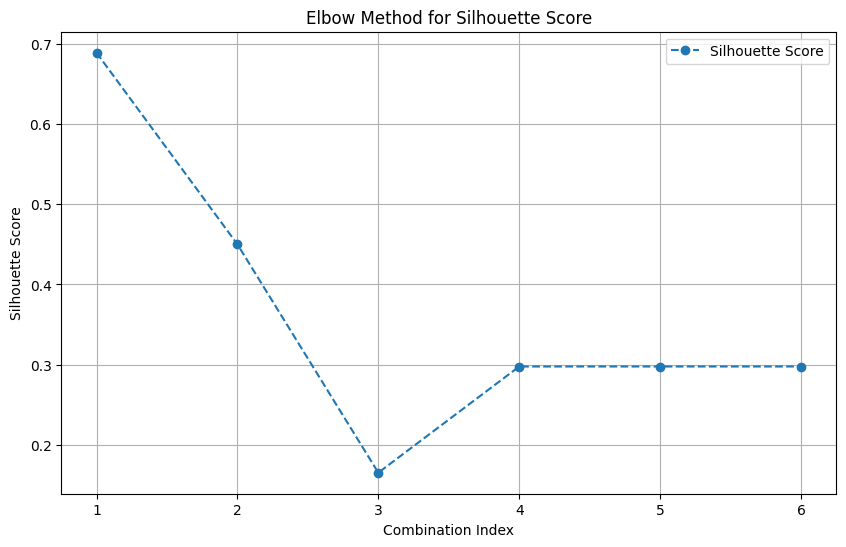

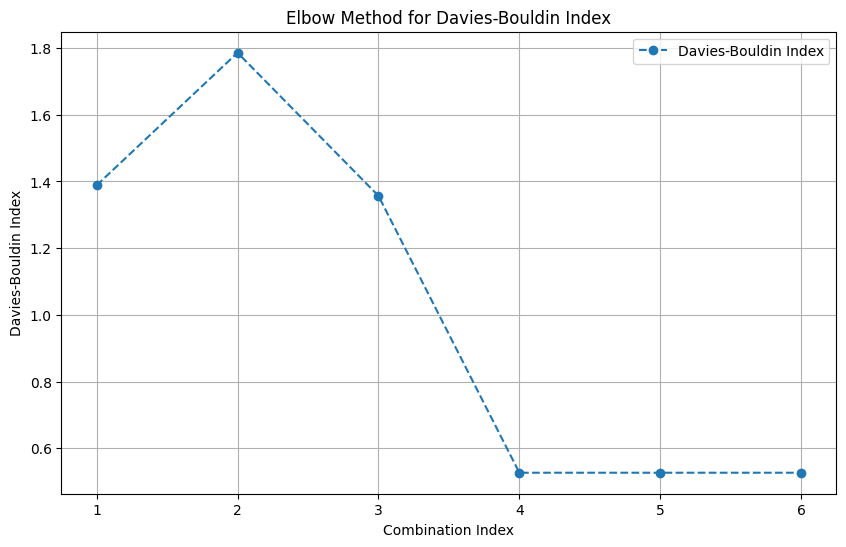

In [78]:
# Mencoba beberapa nilai eps dan min_samples
eps_values = [0.5, 1, 1.5, 2]  # Contoh nilai eps
min_samples_values = [5, 10, 15]  # Contoh nilai min_samples

best_eps = None
best_min_samples = None
best_silhouette_score = -1
best_db_index = float('inf')  # Davies-Bouldin Index, lebih kecil lebih baik

silhouette_scores = []
db_indexes = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(data_scaled)

        # Pastikan ada lebih dari satu cluster
        if len(set(clusters)) > 1:
            # Evaluasi menggunakan Silhouette Score
            silhouette_avg = silhouette_score(data_scaled, clusters)
            silhouette_scores.append((eps, min_samples, silhouette_avg))

            # Evaluasi menggunakan Davies-Bouldin Index
            db_index = davies_bouldin_score(data_scaled, clusters)
            db_indexes.append((eps, min_samples, db_index))

            print(f"For eps={eps}, min_samples={min_samples}, "
                  f"Silhouette Score={silhouette_avg:.4f}, Davies-Bouldin Index={db_index:.4f}")

            # Mencari kombinasi terbaik
            if silhouette_avg > best_silhouette_score or (silhouette_avg == best_silhouette_score and db_index < best_db_index):
                best_silhouette_score = silhouette_avg
                best_db_index = db_index
                best_eps = eps
                best_min_samples = min_samples

# Melakukan clustering dengan parameter terbaik
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_clusters = best_dbscan.fit_predict(data_scaled)

# Menampilkan hasil terbaik
print(f"\nBest eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Best Davies-Bouldin Index: {best_db_index}")

# Menambahkan kolom cluster ke dataframe asli
data['Cluster'] = best_clusters

# Elbow Method (Visualisasi Silhouette Score)
plt.figure(figsize=(10, 6))
scores = [score for _, _, score in silhouette_scores]
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='--', label='Silhouette Score')
plt.title('Elbow Method for Silhouette Score')
plt.xlabel('Combination Index')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid()
plt.show()

# Elbow Method (Visualisasi Davies-Bouldin Index)
plt.figure(figsize=(10, 6))
db_vals = [val for _, _, val in db_indexes]
plt.plot(range(1, len(db_vals) + 1), db_vals, marker='o', linestyle='--', label='Davies-Bouldin Index')
plt.title('Elbow Method for Davies-Bouldin Index')
plt.xlabel('Combination Index')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid()
plt.show()


---

## **6. Visualisasi dan Analisis Hasil Clustering**
Deskripsi
Pada langkah ini, dilakukan visualisasi hasil clustering jika data yang digunakan hanya memiliki dua fitur numerik. Jika lebih dari dua fitur, visualisasi scatter plot tidak didukung. Selain itu, dilakukan analisis terhadap jumlah data poin dalam setiap cluster, termasuk pendeteksian outlier.

In [81]:
# Pastikan data_scaled adalah DataFrame dengan kolom yang sesuai
if len(data_scaled.columns) == 2:  # Jika hanya ada 2 fitur numerik
    plt.figure(figsize=(8, 6))
    plt.scatter(
        data_scaled.iloc[:, 0],  # Kolom pertama (Fitur 1)
        data_scaled.iloc[:, 1],  # Kolom kedua (Fitur 2)
        c=best_clusters,         # Warna berdasarkan hasil clustering
        cmap='viridis',
        s=50,                    # Ukuran marker
        alpha=0.8                # Transparansi
    )
    plt.title('DBSCAN Clustering Visualization')
    plt.xlabel('Fitur 1 (Scaled)')
    plt.ylabel('Fitur 2 (Scaled)')
    plt.colorbar(label='Cluster')
    plt.grid()
    plt.show()
else:
    print("Visualisasi tidak didukung karena jumlah fitur lebih dari 2.")

# Menampilkan hasil clustering
print("\nHasil Clustering:")
print(data.head())

# Analisis lebih lanjut dapat dilakukan berdasarkan nilai cluster
# Contoh: menghitung jumlah data point dalam setiap cluster
cluster_counts = data['Cluster'].value_counts()
print("\nJumlah data point dalam setiap cluster:")
print(cluster_counts)

# Menampilkan cluster dengan outlier (jika ada)
if -1 in cluster_counts.index:  # DBSCAN memberikan label -1 untuk outlier
    print(f"\nJumlah outlier: {cluster_counts[-1]}")
else:
    print("\nTidak ada outlier yang terdeteksi.")


Visualisasi tidak didukung karena jumlah fitur lebih dari 2.

Hasil Clustering:
             Timestamp       Nama Lengkap         NIM Jenis Kelamin    Usia  \
0  30/12/2024 12:25:41       Bayu Maulana   240401068       Laki-Laki    19   
1  30/12/2024 12:26:02    Fajar Fadillah   2400401109       Laki-Laki    18   
2  30/12/2024 12:26:21  Joni Eka Saputra    220401005       Laki-Laki    21   
3  30/12/2024 12:27:03     Nabil munadhil   240401025       Laki-Laki    18   
4  30/12/2024 12:27:49     EVI EKA AZHARI   220401247       Perempuan    21   

  Asal Sekolah             Nama Sekolah         Alamat Sekolah  \
0          SMK              SMK HASANAH           jl cempedak    
1          SMK        SMKN 2 PEKANBARU            Jl.pattimura   
2          SMA       SMAN 11 Pekanbaru               jl.segar    
3           MA           MAN 1 KUANSING  Kab. kuantan singingi   
4          SMA  SMA Negeri 11 Pekanbaru   Jl. Segar, Hangtuah.   

       Jurusan Sekolah               Alamat Domi

## **7. Visualisasi dan Analisis Lebih Lanjut**

In [83]:
# Visualisasi (jika data 2D atau 3D)
if len(data_scaled.columns) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], c=best_clusters, cmap='viridis')
    plt.title('DBSCAN Clustering')
    plt.xlabel('Fitur 1 (Scaled)')
    plt.ylabel('Fitur 2 (Scaled)')
    plt.show()
elif len(data_scaled.columns) == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], c=best_clusters, cmap='viridis')
    ax.set_title('DBSCAN Clustering (3D)')
    ax.set_xlabel('Fitur 1 (Scaled)')
    ax.set_ylabel('Fitur 2 (Scaled)')
    ax.set_zlabel('Fitur 3 (Scaled)')
    plt.show()
else:
    print("Visualisasi scatter plot hanya didukung untuk data 2D atau 3D.")


# Analisis distribusi cluster
cluster_counts = data['Cluster'].value_counts()
print("\nDistribusi Cluster:")
print(cluster_counts)

# Analisis karakteristik setiap cluster (contoh: mean dari fitur 'Usia' untuk setiap cluster)
for cluster_label in cluster_counts.index:
    cluster_data = data[data['Cluster'] == cluster_label]
    mean_usia = cluster_data['Usia'].mean()
    print(f"\nCluster {cluster_label}:")
    print(f"  Rata-rata Usia: {mean_usia}")

Visualisasi scatter plot hanya didukung untuk data 2D atau 3D.

Distribusi Cluster:
Cluster
-1    23
 0    17
 5    15
 3    14
 6    13
 7    10
 1     8
 2     5
 4     5
Name: count, dtype: int64

Cluster -1:
  Rata-rata Usia: 19.91304347826087

Cluster 0:
  Rata-rata Usia: 19.0

Cluster 5:
  Rata-rata Usia: 20.0

Cluster 3:
  Rata-rata Usia: 19.0

Cluster 6:
  Rata-rata Usia: 20.0

Cluster 7:
  Rata-rata Usia: 21.0

Cluster 1:
  Rata-rata Usia: 18.0

Cluster 2:
  Rata-rata Usia: 21.0

Cluster 4:
  Rata-rata Usia: 22.0


## **8. Evaluasi Silhouette Score**

Interpretasi Silhouette Score:

Silhouette Score > 0.5: Cluster yang dihasilkan memiliki kualitas yang baik.
0.25 < Silhouette Score <= 0.5: Cluster yang dihasilkan memiliki kualitas yang cukup baik.
Silhouette Score <= 0.25: Kualitas cluster perlu ditingkatkan. Anda mungkin perlu mencoba mengubah parameter algoritma DBSCAN (misalnya, eps dan min_samples) atau menggunakan metode clustering yang berbeda.

In [84]:
# Evaluasi kualitas cluster (Silhouette Score sudah dihitung sebelumnya)
print(f"\nSilhouette Score terbaik: {best_silhouette_score}")
if best_silhouette_score > 0.5:
    print("Kualitas cluster baik.")
elif best_silhouette_score > 0.25:
    print("Kualitas cluster cukup baik.")
else:
    print("Kualitas cluster perlu ditingkatkan. Pertimbangkan parameter DBSCAN atau metode clustering lain.")


Silhouette Score terbaik: 0.6888213950760451
Kualitas cluster baik.


## **9. Evaluasi Davies-Bouldin Index**

Tahapan ini bertujuan untuk mengevaluasi kualitas cluster menggunakan metrik Davies-Bouldin Index (DBI). DBI adalah metrik internal yang mengukur rata-rata kesamaan antar cluster dibandingkan dengan kesamaan dalam cluster. Semakin rendah nilai DBI, semakin baik kualitas cluster.

In [87]:
# Evaluasi Davies-Bouldin Index
if len(set(best_clusters)) > 1:  # Pastikan ada lebih dari satu cluster
    davies_bouldin = davies_bouldin_score(data_scaled, best_clusters)
    print(f"Davies-Bouldin Index: {davies_bouldin}")
    if davies_bouldin < 1:
        print("Cluster memiliki kualitas yang baik (DB Index mendekati 0).")
    else:
        print("Cluster memiliki kualitas yang perlu ditingkatkan (DB Index besar).")
else:
    print("Davies-Bouldin Index tidak dapat dihitung karena hanya ada satu cluster.")

Davies-Bouldin Index: 1.3884183942534654
Cluster memiliki kualitas yang perlu ditingkatkan (DB Index besar).


## **10. Evaluasi Elbow Method**

Tahapan ini menerapkan Elbow Method untuk membantu menentukan jumlah cluster optimal dalam algoritma K-Means. Meskipun pada penelitian ini menggunakan DBSCAN, Elbow Method lebih umum digunakan untuk K-Means karena  DBSCAN tidak memerlukan penentuan jumlah cluster secara eksplisit.

Interpretasi Elbow Method:

Plot Elbow Method akan menunjukkan kurva yang menurun. Titik "elbow" (siku) pada kurva, di mana penurunan SSE mulai melambat,  mengindikasikan jumlah cluster optimal.  Pada titik ini,  menambahkan lebih banyak cluster tidak akan significantly mengurangi SSE.

Meskipun Elbow Method dapat memberikan petunjuk tentang jumlah cluster yang optimal,  interpretasinya terkadang subjektif. Anda mungkin perlu  mempertimbangkan faktor lain, seperti  konteks data dan tujuan analisis,  dalam menentukan jumlah cluster yang tepat.

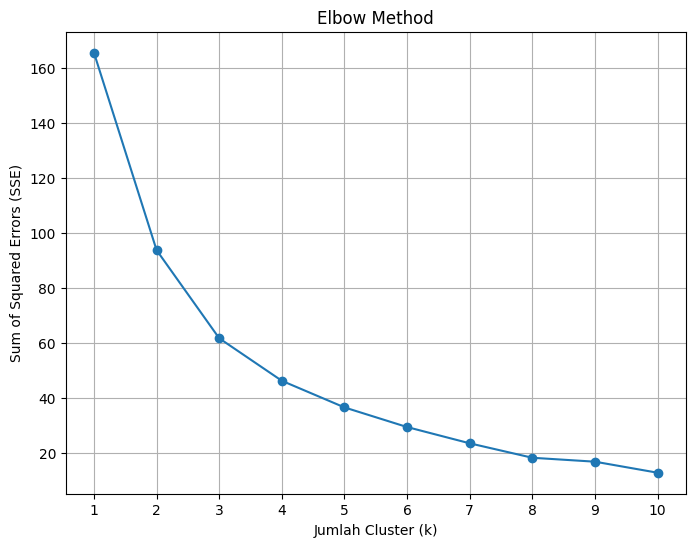


Dari grafik Elbow Method, pilih jumlah cluster (k) di mana kurva mulai mendatar untuk hasil optimal.


In [89]:
# Elbow Method
from sklearn.cluster import KMeans

# Menggunakan KMeans untuk Elbow Method
sse = []  # Sum of Squared Errors
k_range = range(1, 11)  # Coba beberapa nilai k

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

# Visualisasi Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.grid()
plt.show()

print("\nDari grafik Elbow Method, pilih jumlah cluster (k) di mana kurva mulai mendatar untuk hasil optimal.")